In [1]:
%load_ext autoreload    
%autoreload 2

import sys
import os
import numpy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import imageio

sys.path.insert(0, './neural-head-avatars/')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch

In [2]:
from nha.data.real import RealDataModule, tracking_results_2_data_batch
from nha.models.nha_optimizer import NHAOptimizer
from nha.util.general import *

2023-11-30 01:55:37.642876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 01:55:38.503560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dmitry/.miniconda3/envs/nha/lib/python3.9/site-packages/cv2/../../lib64:
2023-11-30 01:55:38.503802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dmitry/.miniconda3/envs/nha/lib/python3.9/sit

In [3]:
driving_ckpt = '/home/dmitry/clones/PanoHead/obama_processed/optimized_avatar/lightning_logs/version_6/checkpoints/joint_optim.ckpt'
target_ckpt = '/home/dmitry/clones/PanoHead/dataset/dmitry_result/lightning_logs/version_40/checkpoints/last.ckpt'
driving_tracking_results = np.load('/home/dmitry/clones/PanoHead/obama_processed/tracking/tracking_3/tracked_flame_params.npz')
target_tracking_results = np.load('/home/dmitry/clones/PanoHead/dataset/dmitry_tracking/tracking_0/tracked_flame_params.npz')
neutral_driving_frame = 0
neutral_target_frame = 1
outpath = '/home/dmitry/clones/PanoHead/obama_processed/reenactment'
target_load_threeddfa_data = '/home/dmitry/clones/PanoHead/dataset/testdata_img/dataset.json'

In [4]:
%cd neural-head-avatars

/home/dmitry/clones/PanoHead/neural-head-avatars


In [5]:
from nha.data.real import RealDataModule
from nha.models.nha_optimizer import NHAOptimizer, create_camera_objects
from nha.util.general import dict_2_device
import pytorch_lightning as pl
from pytorch3d.structures import Meshes
from configargparse import ArgumentParser as ConfigArgumentParser
from argparse import ArgumentParser

In [6]:
def get_model_and_data(ckpt_file, config_file, **kwargs):

    optimizer_module = NHAOptimizer
    data_module = RealDataModule

    parser = ArgumentParser()
    parser = optimizer_module.add_argparse_args(parser)
    parser = data_module.add_argparse_args(parser)
    parser = pl.Trainer.add_argparse_args(parser)

    parser = ConfigArgumentParser(parents=[parser], add_help=False)
    parser.add_argument('--config', required=True, is_config_file=True)
    parser.add_argument("--checkpoint_file", type=str, required=False, default="",
                        help="checkpoint to load model from")

    args = parser.parse_args([
        '--config', config_file,
        '--checkpoint_file', ckpt_file,
    ])
    for k, v in kwargs.items():
        setattr(args, k, v)
    args_dict = vars(args)

    # print(f"Start Model training with the following configuration: \n {parser.format_values()}")

    # init datamodule
    data = data_module(**args_dict)
    data.setup()

    # init optimizer
    args_dict['max_frame_id'] = data.max_frame_id

    if args.checkpoint_file:
        model = optimizer_module.load_from_checkpoint(args.checkpoint_file, strict=True, **args_dict)
    else:
        model = optimizer_module(**args_dict)

    return model, data


In [8]:
target_model, target_data = get_model_and_data(
    '/home/dmitry/clones/PanoHead/dataset/dmitry_result/lightning_logs/version_40/checkpoints/last.ckpt',
    'configs/optimize_avatar_dmitry.ini'
)
target_model.cuda()
driving_model, driving_data = get_model_and_data(
    '/home/dmitry/clones/PanoHead/obama_processed/optimized_avatar/lightning_logs/version_6/checkpoints/joint_optim.ckpt',
    'configs/optimize_avatar_obama.ini'
)
driving_model.cuda();

In [9]:
target_sample = dict_2_device(next(iter(target_data.train_dataloader(1, shuffle=False))), 'cuda')
driving_sample = dict_2_device(next(iter(driving_data.train_dataloader(1, shuffle=False))), 'cuda')

Text(0.5, 1.0, 'driving')

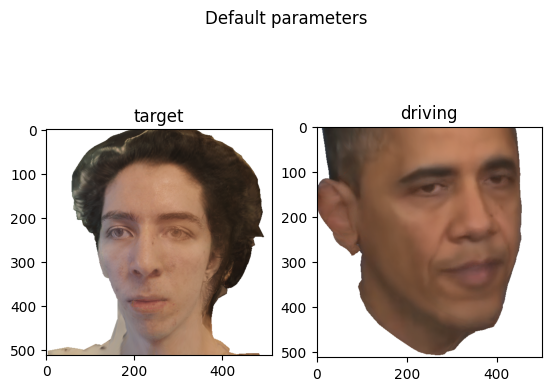

In [10]:
plt.suptitle("Default parameters")
with torch.no_grad():
    target_rgba = target_model(target_sample)
    driving_rgba = driving_model(driving_sample)
plt.subplot(1, 2, 1)
plt.imshow(target_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('target')
plt.subplot(1, 2, 2)
plt.imshow(driving_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('driving')

Text(0.5, 1.0, 'driving')

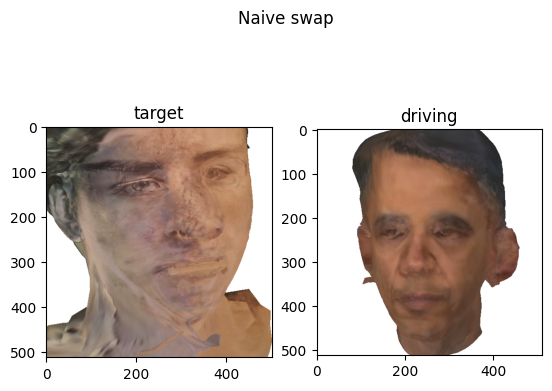

In [11]:
plt.suptitle('Naive swap')
# Switch up parameters
with torch.no_grad():
    target_rgba = target_model(driving_sample)
    driving_rgba = driving_model(target_sample)
plt.subplot(1, 2, 1)
plt.imshow(target_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('target')
plt.subplot(1, 2, 2)
plt.imshow(driving_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('driving')

In [9]:
pose_keys = ['flame_pose', 'flame_trans', 'flame_scale', 'cam_intrinsic', 'cam_extrinsic']

Text(0.5, 1.0, 'driving')

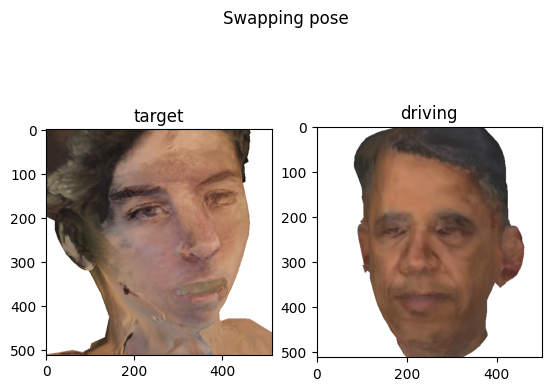

In [25]:
plt.suptitle('Swapping pose')


driving_sample_copy = dict(**driving_sample)
target_sample_copy = dict(**target_sample)
for key in pose_keys:
    driving_sample_copy[key], target_sample_copy[key] = target_sample[key], driving_sample[key]
# Switch up parameters
with torch.no_grad():
    target_rgba = target_model(target_sample_copy)
    driving_rgba = driving_model(driving_sample_copy)
plt.subplot(1, 2, 1)
plt.imshow(target_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('target')
plt.subplot(1, 2, 2)
plt.imshow(driving_rgba[0, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title('driving')

In [10]:
import cv2
batch_size = 8
driving_loader = driving_data.train_dataloader(batch_size, shuffle=False)
outpath = 'animation_transfer'
os.makedirs(outpath, exist_ok=True)

counter = 0
for driving_batch in tqdm(driving_loader):
    driving_batch = dict_2_device(driving_batch, 'cuda')
    for key in pose_keys:
        target_sample[key] = driving_batch[key]
    target_sample['flame_shape'] = target_sample['flame_shape'][:1].expand(len(driving_batch['flame_shape']), -1)
    target_sample['flame_expr'] = target_sample['flame_expr'][:1].expand(len(driving_batch['flame_expr']), -1)
    target_sample['flame'] = target_sample['flame_shape'][:1].expand(len(driving_batch['flame_shape']), -1)
    with torch.no_grad():
        target_rgba = target_model(target_sample)

    for i in range(len(target_rgba)):
        img = ((target_rgba[i, :3].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5) * 255).astype(np.uint8)
        img = cv2.resize(img, (128, 128))
        cv2.imwrite(f'{outpath}/{counter:05d}.png', img[:, :, ::-1])
        counter += 1


  0%|          | 0/52 [00:00<?, ?it/s]

# Bugfixing

In [33]:
from nha.util.render import create_camera_objects
from pytorch3d.structures import Meshes
from pytorch3d.renderer import rasterize_meshes
from pytorch3d.renderer.mesh.rasterizer import Fragments

def render_mesh(model, verts, faces, batch):
    K = batch["cam_intrinsic"]
    RT = batch["cam_extrinsic"]
    H, W = batch["rgb"].shape[-2:]
    eps = 1e-8

    cameras = create_camera_objects(K, RT, (H, W), model.device)
    meshes = Meshes(verts=[verts] * len(K), faces=[faces] * len(K))

    verts_world = meshes.verts_padded()
    verts_view = cameras.get_world_to_view_transform().transform_points(verts_world, eps=eps)
    projection_trafo = cameras.get_projection_transform().compose(cameras.get_ndc_camera_transform())
    verts_ndc = projection_trafo.transform_points(verts_view, eps=eps)
    verts_ndc[..., 2] = verts_view[..., 2]

    if True: # center_prediction
        centers = 0.5 * (verts_ndc[..., :2].max(dim=-2, keepdim=True).values +
                            verts_ndc[..., :2].min(dim=-2, keepdim=True).values)
        verts_ndc[..., :2] = verts_ndc[..., :2] - centers

    meshes_ndc = meshes.update_padded(new_verts_padded=verts_ndc)

    perspective_correct = cameras.is_perspective()
    znear = cameras.get_znear()
    if isinstance(znear, torch.Tensor):
        znear = znear.min().item()
    z_clip = None if not perspective_correct or znear is None else znear / 2

    with torch.no_grad():
        fragments = rasterize_meshes(
            meshes_ndc,
            image_size=(H, W),
            blur_radius=0,
            faces_per_pixel=2,
            bin_size=None,
            max_faces_per_bin=None,
            clip_barycentric_coords=False,
            perspective_correct=True,
            cull_backfaces=False,
            z_clip_value=z_clip,
            cull_to_frustum=False,
        )
        return Fragments(
            pix_to_face=fragments[0],
            zbuf=fragments[1],
            bary_coords=fragments[2],
            dists=fragments[3],
        )

In [34]:
import trimesh
mesh_path = "/home/dmitry/clones/PanoHead/pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/PTI_render/post_mesh/mesh.obj"
mesh = trimesh.load_mesh(mesh_path)

In [31]:
mesh.vertices.shape, mesh.faces.max()

((231391, 3), 231390)

In [35]:
render_mesh(m1, torch.tensor(mesh.vertices).cuda().float(), torch.tensor(mesh.faces).cuda().long(), s1)

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
m1, d1 = get_model_and_data(
    '/home/dmitry/clones/PanoHead/dataset/dmitry_result/lightning_logs/version_38/checkpoints/last.ckpt',
    'configs/optimize_avatar_dmitry.ini'
)
m1.cuda()
m2, d2 = get_model_and_data(
    '/home/dmitry/clones/PanoHead/dataset/dmitry_result/lightning_logs/version_39/checkpoints/last.ckpt',
    'configs/optimize_avatar_dmitry.ini'
)
m2.cuda();

/home/dmitry/.miniconda3/envs/nha/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: ModelCheckpoint(save_last=True, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  warnings.warn(*args, **kwargs)


In [16]:
s1 = dict_2_device(next(iter(d1.train_dataloader(2, shuffle=False))), 'cuda')
s2 = dict_2_device(next(iter(d2.train_dataloader(2, shuffle=False))), 'cuda')

In [19]:
s1['cam_extrinsic'][1]

tensor([[ 4.0121e-01, -1.0964e-01, -9.0940e-01, -2.6135e-08],
        [ 1.0537e-01, -9.8033e-01,  1.6688e-01, -1.0331e-06],
        [-9.0981e-01, -1.6278e-01, -3.8177e-01,  2.7000e+00]], device='cuda:0')

In [20]:
s2['cam_extrinsic'][1]

tensor([[ 4.0121e-01, -1.0964e-01, -9.0940e-01, -2.6135e-08],
        [ 1.0537e-01, -9.8033e-01,  1.6688e-01, -1.0331e-06],
        [-9.0981e-01, -1.6278e-01, -3.8177e-01,  2.7000e+00]], device='cuda:0')

In [22]:
s1['flame_pose'] - s2['flame_pose']

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

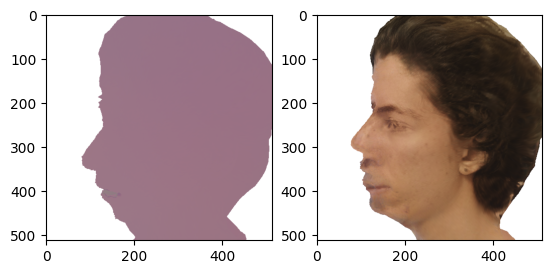

In [17]:
with torch.no_grad():
    r1 = m1(s1)
    r2 = m2(s2)

plt.subplot(1, 2, 1)
plt.imshow(r1[1, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.subplot(1, 2, 2)
plt.imshow(r2[1, :3].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)